# Imports + Colab

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/ProgettoNAPDE/ProgettoNAPDE

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/ProgettoNAPDE/ProgettoNAPDE


In [2]:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

--2024-11-13 07:24:16--  https://fem-on-colab.github.io/releases/firedrake-install-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4585 (4.5K) [application/x-sh]
Saving to: ‘/tmp/firedrake-install.sh’

/tmp/firedrake-inst 100%[===================>]   4.48K  --.-KB/s    in 0s      

2024-11-13 07:24:16 (46.4 MB/s) - ‘/tmp/firedrake-install.sh’ saved [4585/4585]

+ INSTALL_PREFIX=/usr/local
++ awk -F/ '{print NF-1}'
++ echo /usr/local
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FIREDRAKE_INSTALLED=/usr/local/share/fem-on-colab/firedrake.installed
+ [[ ! -f /usr/local/share/fem-on-colab/firedrake.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/7b6613c7/rel

/usr/local/lib/python3.10/dist-packages/pytools/persistent_dict.py:63: RecommendedHashNotFoundWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "


In [3]:
%cd ../../../PyGeM
%ls

/gdrive/My Drive/PyGeM
build/             dist/         LICENSE.rst      readme/    test.py
CITATION.cff       dockerfiles/  pygem/           README.md  tests/
code_formatter.sh  docs/         pygem.egg-info/  setup.py   tutorials/


In [4]:
!python3.10 setup.py install
import pygem

running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https

In [5]:
%cd ../Colab Notebooks/ProgettoNAPDE/ProgettoNAPDE
%ls

/gdrive/My Drive/Colab Notebooks/ProgettoNAPDE/ProgettoNAPDE
 gmshcommands.txt   Progetto_Napde_final.ipynb   testairfoil.geo
 output/           'Progetto Napde.ipynb'        testairfoil.msh


## Imports

In [6]:
from firedrake import *
import matplotlib.pyplot as plt
from pygem import FFD, RBF
import numpy as np

# Import the mesh

In [ ]:
M = Mesh('testairfoil.msh')

# Plot the mesh

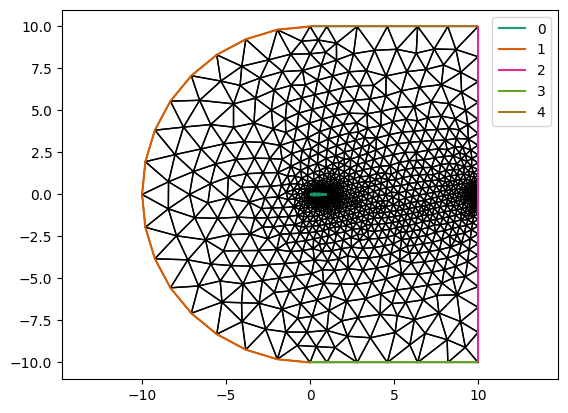

In [ ]:
fig, ax = plt.subplots()
triplot(M, axes=ax)
ax.axis('equal')
ax.legend()

(-0.35, 0.35)

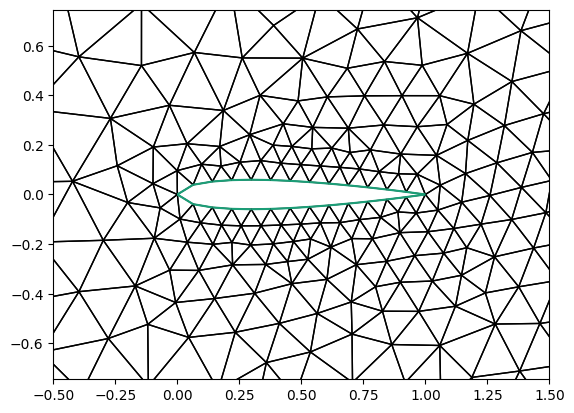

In [ ]:
fig, ax = plt.subplots()
triplot(M, axes=ax)
ax.axis('equal')
ax.set_xlim(-0.5,1.5)
ax.set_ylim(-0.35,0.35)

# Solve problem with SUPG N-S with Stokes starting point

## Solve stokes to obtain a starting point

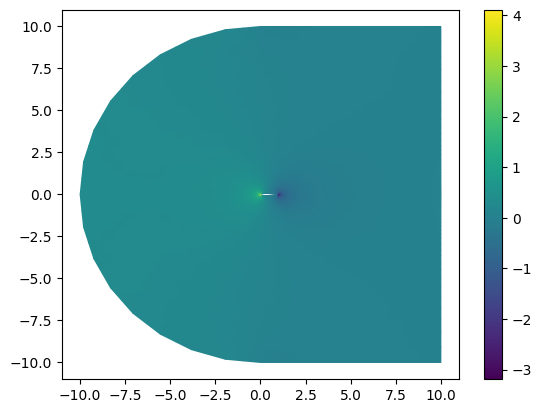

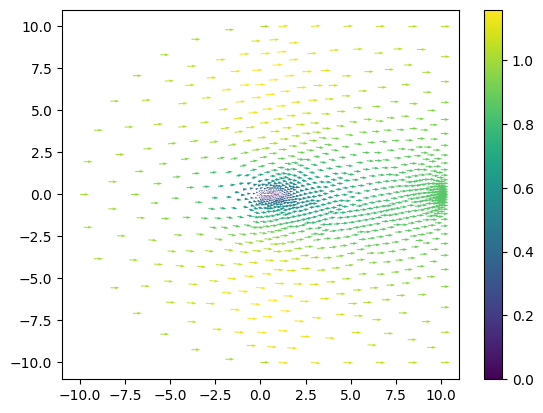

In [ ]:
# function space
V=VectorFunctionSpace(M, 'P', 2) # velocity
Q=FunctionSpace(M, 'P', 1) # pressure
W=MixedFunctionSpace([V, Q])

# trial and test functions
u, p=TrialFunctions(W)
v, q=TestFunctions(W)

# data
x=SpatialCoordinate(M)
Uinf=as_vector([1,0])

# problem
a=inner(grad(u), grad(v))*dx - p*div(v)*dx+ q*div(u)*dx
L=inner(Constant((0,0)),v)*dx

# Dirichlet BC
bc1=DirichletBC(W.sub(0), as_vector([0,0]), 0)
bc2=DirichletBC(W.sub(0), Uinf, 1)
bcs=(bc1, bc2)

#solution
w_stokes=Function(W)
solve(a==L, w_stokes, bcs=bcs)
# u_h, p_h=split(wh) no split command works only for trial and test funtion
u_stokes, p_stokes=w_stokes.subfunctions

fig, ax = plt.subplots()
q=tripcolor(p_stokes, axes=ax)
fig.colorbar(q)
fig, ax = plt.subplots()
q=quiver(u_stokes, axes=ax)
fig.colorbar(q)

## Set Reynolds Number


In [ ]:
Re = Constant(3500)

## Solve Navier Stokes with SUPG Stabilization

In [ ]:
def a(u,v, Re):
    return 1/Re*inner(grad(u), grad(v))*dx

def c(w,u,v):
    return inner(dot(grad(u), w),v)*dx

def b(v,q):
    return -q*div(v)*dx

def stabilization(u_old, u, p, v, q, M, Re):
    ubar = Function(FunctionSpace(M, 'DG', 0))
    ubar.project(sqrt(inner(u_old, u_old)))
    h = CellDiameter(M)
    Re_K = h * ubar * Re
    one  = Constant(1.0)
    delta=Constant(1.0)
    delta_K = delta * conditional(gt(Re_K, one),  h/(ubar+1e-5), h*h*Re)

    L= -1.0/Re*div(grad(u))+ dot(grad(u_old), u) + dot(grad(u), u_old)+ grad(p)
    Lss = dot(grad(u_old),v) + dot(grad(v),u_old) + grad(q)+ 0.5*div(u_old)*v

    lhs= delta_K * inner(L, Lss)*dx + delta_K*div(u)*div(v)*dx
    rhs=delta_K*inner(dot(grad(u_old), u_old), Lss)*dx

    return lhs, rhs


In [ ]:
# Function spaces (mixed formulation)
V = VectorFunctionSpace(M, 'P', 2)
Q = FunctionSpace(M, 'P', 1)
W = MixedFunctionSpace([V, Q])

# Data and boundary conditions
f = Constant((0.,0.))

u_in = as_vector([1., 0.])

bc1 = DirichletBC(W.sub(0), Constant((0.,0.)), 0) # Dirichlet no-slip B.C. on the airfoil
bc2 = DirichletBC(W.sub(0), u_in, 1) # Dirichlet unitary B.C. on the inflow boundary
bc3 = DirichletBC(W.sub(1), 0, 0) # Dirichlet unitary B.C. on the inflow boundary
bcs = (bc1, bc2)

In [ ]:
# Trial and test functions
u, p = TrialFunctions(W) # trial functions
v, q = TestFunctions(W) # test functions

param = {'ksp_type':'gmres',
         'ksp_pc_type':'ilu',
         'ksp_maxit':1000,
         'ksp_rtol':1e-8,
         'snes_rtol':1e-3,
         'snes_maxit':100,
       }

# solution
wh = Function(W)
uh, ph = wh.subfunctions
wh.assign(w_stokes) #initialization with stokes solution

maxit=100
tol=1e-8
it=0
err=tol+1
delta=1

u_old = Function(V)
u_old.assign(uh)
p_old = Function(Q)
p_old.assign(ph)



while it < maxit and err > tol:
  lhs, rhs = stabilization(u_old, u, p, v, q, M, Re)
  G = a(u,v,Re) + c(u,u_old,v)+c(u_old,u,v)-b(u,q)+b(v,p)+lhs
  L = inner(f,v)*dx +rhs + c(u_old, u_old,v)
  pb = LinearVariationalProblem(G, L , wh, bcs=bcs)
  solver = LinearVariationalSolver(pb, solver_parameters=param)
  solver.solve()
  uh, ph = wh.subfunctions
  err = (errornorm(uh, u_old, 'H1') / norm(u_old, 'H1') + errornorm(ph, p_old, 'L2') / norm(p_old, 'L2'))
  u_old.assign(uh)
  p_old.assign(ph)
  it+=1

print(it)

21


## Plotting the solution

In [ ]:
uh, ph = wh.subfunctions
outfileU = File("output/velocity.pvd")
outfileP = File("output/pressure.pvd")
uh.rename("Velocity")   # this name will be used in Paraview
ph.rename("Pressure")   # this name will be used in Paraview
outfileU.write(uh)
outfileP.write(ph)

/Users/guidopoletti/firedrake/src/firedrake/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(


(-3.0, 3.0)

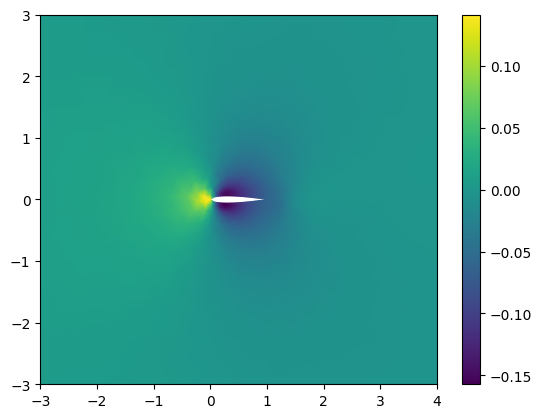

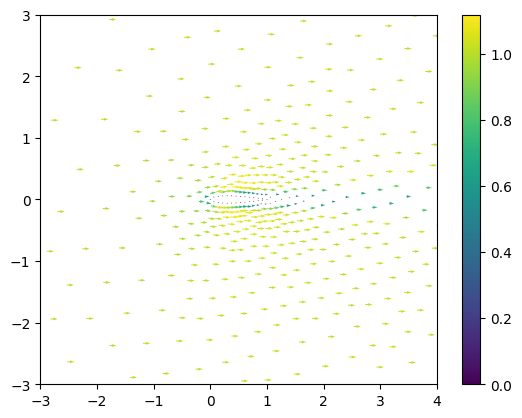

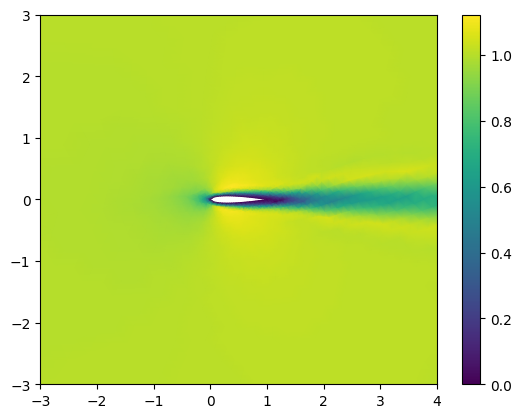

In [ ]:
u_h, p_h = wh.subfunctions
fig, ax = plt.subplots()
q=tripcolor(p_h, axes=ax)
fig.colorbar(q)
ax.set_xlim(-3, 4)
ax.set_ylim(-3, 3)

fig, ax = plt.subplots()
q=quiver(u_h, axes=ax)
fig.colorbar(q)
ax.set_xlim(-3, 4)
ax.set_ylim(-3, 3)

fig, ax = plt.subplots()
q=tripcolor(u_h, axes=ax)
fig.colorbar(q)
ax.set_xlim(-3, 4)
ax.set_ylim(-3, 3)

## Computing lift and drag coefficients

In [ ]:
T=p_h * Identity(2) - 1/Re * (grad(u_h) + grad(u_h).T)
n=FacetNormal(M)
Cd=assemble(inner(T*n, as_vector([1,0]))*ds(0))/0.5
Cl=assemble(inner(T*n, as_vector([0,1]))*ds(0))/0.5
print(Cd)
print(Cl)

0.035144581334309
0.0010676623510121484


# Mesh deformation

## Node Extraction

In [ ]:
coord=M.coordinates.dat.data
coord.shape

(1020, 2)

In [ ]:
#extend coord to make it work with FFD
coord = np.c_[coord,np.ones(coord.shape[0])]

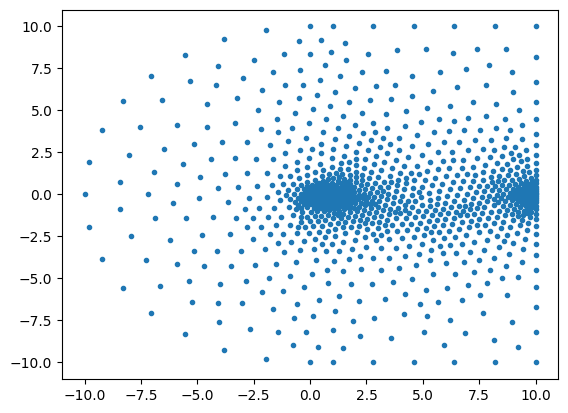

In [ ]:
plt.plot(coord[:,0], coord[:,1], '.')

In [ ]:
X = VectorFunctionSpace(M, 'P', 1)

b1 = DirichletBC(X, Constant((0.,0.)), 0) # Dirichlet no-slip B.C. on the airfoil
b2 = DirichletBC(X, Constant((0.,0.)), [1, 2, 3, 4]) # Dirichlet unitary B.C. on the inflow boundary


(np.float64(-0.049999999999999996),
 np.float64(1.05),
 np.float64(-0.06543444532783949),
 np.float64(0.06543444532751576))

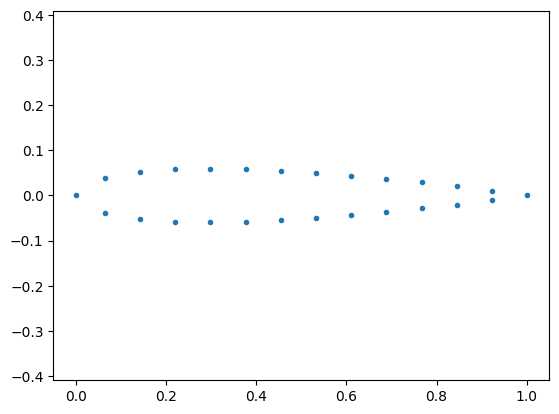

In [ ]:
#extract obstacle points
obstacle=coord[b1.nodes, :]
plt.plot(obstacle[:,0], obstacle[:,1], '.')
plt.axis('equal')

(np.float64(-11.0), np.float64(11.0), np.float64(-11.0), np.float64(11.0))

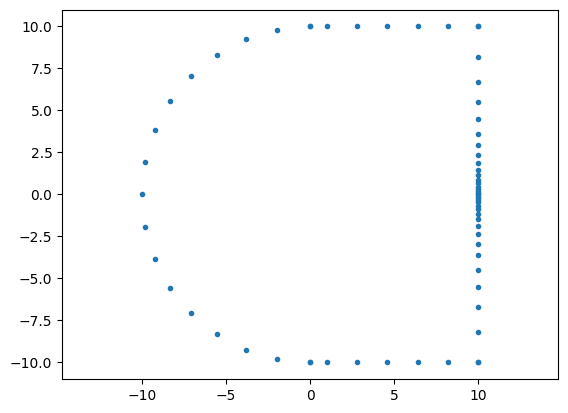

In [ ]:
ext_boundary=coord[b2.nodes, :]
plt.plot(ext_boundary[:,0], ext_boundary[:,1], '.')
plt.axis('equal')


## Airfoil deformation

In [ ]:
ffd = FFD([5, 2, 1]) #initialize free-form deformation object with the dimensions of the matrix of control points

#define bounding box in which object to deform is contained (position of control points)

ffd.box_origin = np.array([-0.2,-0.5,0.9])
ffd.box_length = np.array([1.4,1,1.1])


(np.float64(-0.3020833333333333),
 np.float64(1.3020833333333333),
 np.float64(-0.8020833333333333),
 np.float64(0.8020833333333333),
 np.float64(0.34843749999999996),
 np.float64(1.5515625))

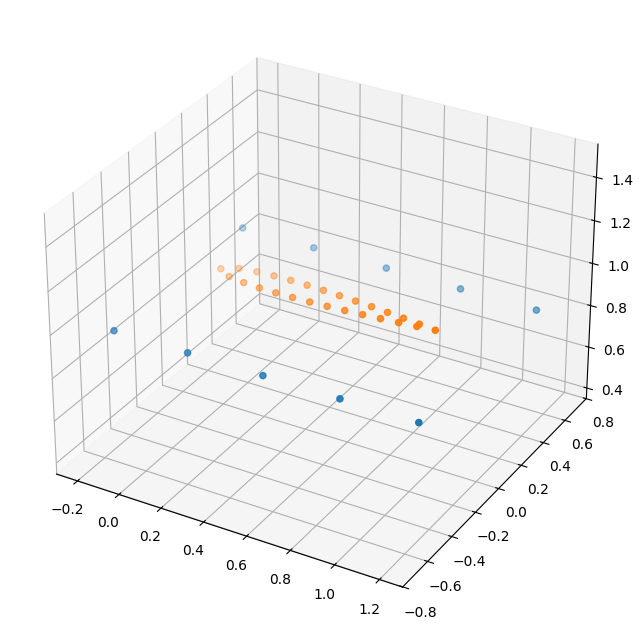

In [ ]:
ax = plt.figure(figsize=(8,8)).add_subplot(111, projection='3d')
ax.scatter(*ffd.control_points().T)
ax.scatter(obstacle[:,0],obstacle[:,1],obstacle[:,2])
ax.axis('equal')

In [ ]:
#define movement in each direction for each control point

#ffd.array_mu_x[2, 2, 0] = 0.5
ffd.array_mu_y[2,0,0] = -0.1
#ffd.array_mu_z[1, 1, 0] = 0.

(np.float64(-0.05000000000000001),
 np.float64(1.0500000000000003),
 np.float64(-0.08471689655560151),
 np.float64(0.06635265729074252))

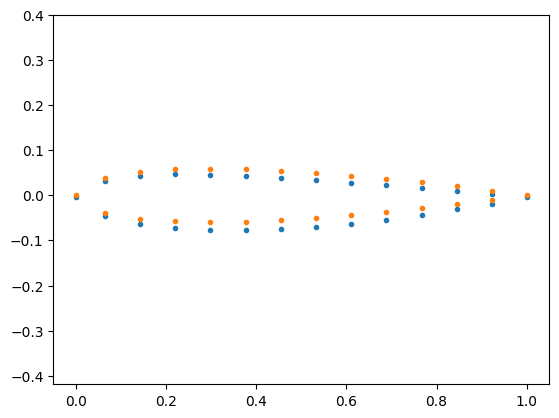

In [ ]:
new_obstacle = ffd(obstacle)
plt.plot(new_obstacle[:,0], new_obstacle[:,1], '.')
plt.plot(obstacle[:,0], obstacle[:,1], '.')
plt.axis('equal')

In [ ]:
undeformed_points_full = np.vstack([ext_boundary, obstacle])
deformed_points_full= np.vstack([ext_boundary, new_obstacle])

undeformed_points, uindexes = np.unique(undeformed_points_full, return_index=True, axis=0)
deformed_points   = deformed_points_full[uindexes]

rbf = RBF(original_control_points=undeformed_points, deformed_control_points=deformed_points)

In [ ]:
#propagate deformation to the whole mesh
new_coord=rbf(coord)

(np.float64(-11.000000000372529),
 np.float64(11.00000000782311),
 np.float64(-11.000002098083495),
 np.float64(11.000002098083495))

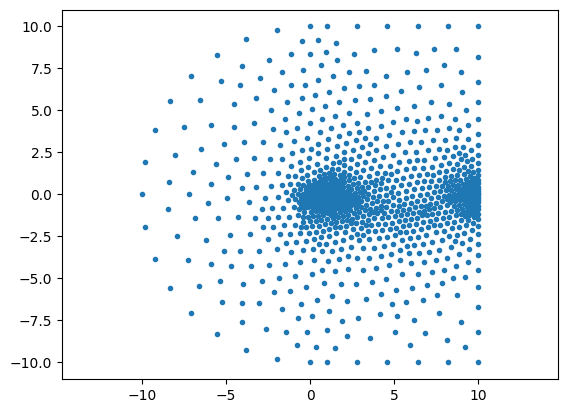

In [ ]:
plt.plot(new_coord[:,0], new_coord[:,1], '.')
plt.axis('equal')

In [ ]:
new_coords_func = Function(M.coordinates.function_space())
new_coords_func.dat.data[:] = new_coord[:,:2]
M.coordinates.assign(new_coords_func)


Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x151af0a90>, VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 1857)), 2776)

(-0.35, 0.35)

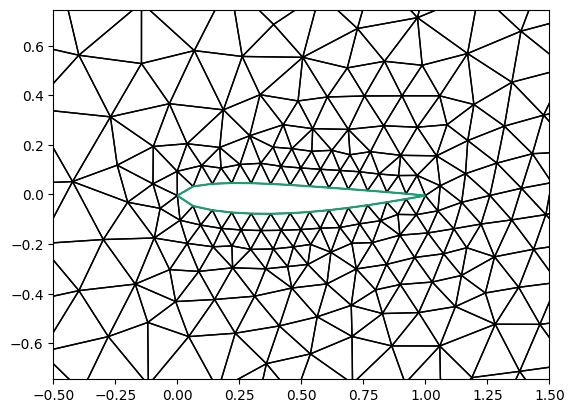

In [ ]:
fig, ax = plt.subplots()
triplot(M, axes=ax)
ax.axis('equal')
ax.set_xlim(-0.5,1.5)
ax.set_ylim(-0.35,0.35)

# Reinforcement learning

## CFD solver

In [ ]:
M = Mesh('testairfoil.msh')

In [32]:
class CFDSolver:
    def __init__(self, mesh, reynolds_number):
        self.mesh = mesh
        self.Re = reynolds_number

        # Define finite element spaces and mixed formulation (Velocity and Pressure)
        self.V = VectorFunctionSpace(mesh, 'P', 2)
        self.Q = FunctionSpace(mesh, 'P', 1)
        self.W = MixedFunctionSpace([self.V, self.Q])

        # Define data
        self.f=Constant((0.,0.))

        # Define boundary conditions
        self.define_boundary_conditions()

        # Initialize the problem
        self.wh = Function(self.W)  # Solution function (velocity, pressure)
        self.uh, self.ph = self.wh.split()

    def define_boundary_conditions(self):
        u_in = as_vector([1., 0.])
        bc1 = DirichletBC(self.W.sub(0), Constant((0.,0.)), 0) # No-slip on airfoil
        bc2 = DirichletBC(self.W.sub(0), u_in, 1) # Unitary inflow condition
        self.bcs = [bc1, bc2]

    def solve_stokes(self):
        # Define the trial and test functions
        u, p = TrialFunctions(self.W)
        v, q = TestFunctions(self.W)

        # Define the Stokes variational problem (no convective term)
        a_stokes = (1/self.Re) * inner(grad(u), grad(v)) * dx - div(v) * p * dx - q * div(u) * dx
        L_stokes = inner(Constant((0., 0.)), v) * dx  # No external force

        # Solve the Stokes problem
        wh_stokes = Function(self.W)
        init_problem = LinearVariationalProblem(a_stokes, L_stokes, wh_stokes, bcs=self.bcs)
        solver_init =  LinearVariationalSolver(init_problem)
        solver_init.solve()

        # Assign Stokes solution to initial values of Navier-Stokes solver
        self.wh.assign(wh_stokes)
        print("Stokes solution computed and set as initial condition.")

    def run_solver(self):

        def a(u,v, Re):
            return 1/Re*inner(grad(u), grad(v))*dx

        def c(w,u,v):
            return inner(dot(grad(u), w),v)*dx

        def b(v,q):
            return -q*div(v)*dx

        def stabilization(u_old, u, p, v, q, M, Re):
            ubar = Function(FunctionSpace(M, 'DG', 0))
            ubar.project(sqrt(inner(u_old, u_old)))
            h = CellDiameter(M)
            Re_K = h * ubar * Re
            one  = Constant(1.0)
            delta=Constant(1.0)
            delta_K = delta * conditional(gt(Re_K, one),  h/(ubar+1e-5), h*h*Re)

            L= -1.0/Re*div(grad(u))+ dot(grad(u_old), u) + dot(grad(u), u_old)+ grad(p)
            Lss = dot(grad(u_old),v) + dot(grad(v),u_old) + grad(q)

            lhs= delta_K * inner(L, Lss)*dx + delta_K*div(u)*div(v)*dx
            rhs=delta_K*inner(dot(grad(u_old), u_old), Lss)*dx

            return lhs, rhs

        # First, solve the Stokes problem for initialization
        self.solve_stokes()

        # Define the trial and test functions
        u, p = TrialFunctions(self.W)
        v, q = TestFunctions(self.W)

        maxit = 1000
        tol = 1e-8
        it = 0
        err = tol + 1

        # Prepare previous solution functions for iterations
        u_old = Function(self.V)
        u_old.assign(self.uh)
        p_old = Function(self.Q)
        p_old.assign(self.ph)

        param = {'ksp_type':'gmres',
         'ksp_pc_type':'ilu',
         'ksp_maxit':1000,
         'ksp_rtol':1e-8,
       }

        while it < maxit and err > tol:
          it+=1
          lhs, rhs = stabilization(u_old, u, p, v, q, self.mesh, self.Re)
          G = a(u,v,self.Re) + c(u,u_old,v)+c(u_old,u,v)-b(u,q)+b(v,p)+lhs
          L = inner(self.f,v)*dx + rhs + c(u_old, u_old,v)
          pb = LinearVariationalProblem(G, L , self.wh, bcs=self.bcs)
          solver = LinearVariationalSolver(pb, solver_parameters=param)
          solver.solve()
          self.uh, self.ph = self.wh.subfunctions

          err = (errornorm(self.uh, u_old, 'H1') / norm(u_old, 'H1') + errornorm(self.ph, p_old, 'L2') / norm(p_old, 'L2'))

          u_old.assign(self.uh)
          p_old.assign(self.ph)

        if it>maxit:
            print("Max iterations reached")
        else:
            print("Solver converged in", it, "iterations")

        # Calculate Cd and Cl
        Cd, Cl = self.calculate_drag_lift()
        return Cd, Cl

    def calculate_drag_lift(self):
        T=self.ph * Identity(2) - 1/(self.Re) * (grad(self.uh) + grad(self.uh).T)
        n=FacetNormal(self.mesh)
        Cd=assemble(inner(T*n, as_vector([1,0]))*ds(0))/0.5
        Cl=assemble(inner(T*n, as_vector([0,1]))*ds(0))/0.5
        return Cd, Cl

    def plot_solution(self):
        fig, ax = plt.subplots()
        q=tripcolor(self.ph, axes=ax)
        fig.colorbar(q)
        ax.set_xlim(-3, 4)
        ax.set_ylim(-3, 3)

        fig, ax = plt.subplots()
        q=quiver(self.uh, axes=ax)
        fig.colorbar(q)
        ax.set_xlim(-3, 4)
        ax.set_ylim(-3, 3)

In [ ]:
CFDsolver=CFDSolver(M, 3500)

/usr/local/lib/python3.10/dist-packages/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)


In [ ]:
CFDsolver.run_solver()

/usr/local/lib/python3.10/dist-packages/loopy/schedule/__init__.py:2255: LoopyWarning: in kernel form0_cell_integral: Falling back to a slow scheduler implementation due to: cannot schedule kernels with priority dependencies between sibling loop nests (add 'v1_scheduler_fallback' to silenced_warnings kernel attribute to disable)
  warn_with_kernel(
/usr/local/lib/python3.10/dist-packages/loopy/schedule/__init__.py:2255: LoopyWarning: in kernel wrap_form0_cell_integral: Falling back to a slow scheduler implementation due to: cannot schedule kernels with priority dependencies between sibling loop nests (add 'v1_scheduler_fallback' to silenced_warnings kernel attribute to disable)
  warn_with_kernel(
/usr/local/lib/python3.10/dist-packages/loopy/schedule/__init__.py:2255: LoopyWarning: in kernel form1_cell_integral: Falling back to a slow scheduler implementation due to: cannot schedule kernels with priority dependencies between sibling loop nests (add 'v1_scheduler_fallback' to silenced_

Stokes solution computed and set as initial condition.


/usr/local/lib/python3.10/dist-packages/loopy/schedule/__init__.py:2255: LoopyWarning: in kernel form0_cell_integral: Falling back to a slow scheduler implementation due to: cannot schedule kernels with priority dependencies between sibling loop nests (add 'v1_scheduler_fallback' to silenced_warnings kernel attribute to disable)
  warn_with_kernel(
/usr/local/lib/python3.10/dist-packages/loopy/schedule/__init__.py:2255: LoopyWarning: in kernel form0_cell_integral: Falling back to a slow scheduler implementation due to: cannot schedule kernels with priority dependencies between sibling loop nests (add 'v1_scheduler_fallback' to silenced_warnings kernel attribute to disable)
  warn_with_kernel(
/usr/local/lib/python3.10/dist-packages/loopy/schedule/__init__.py:2255: LoopyWarning: in kernel wrap_form0_cell_integral: Falling back to a slow scheduler implementation due to: cannot schedule kernels with priority dependencies between sibling loop nests (add 'v1_scheduler_fallback' to silenced_

Solver converged in 21 iterations


/usr/local/lib/python3.10/dist-packages/loopy/schedule/__init__.py:2255: LoopyWarning: in kernel wrap_form_exterior_facet_integral: Falling back to a slow scheduler implementation due to: cannot schedule kernels with priority dependencies between sibling loop nests (add 'v1_scheduler_fallback' to silenced_warnings kernel attribute to disable)
  warn_with_kernel(
/usr/local/lib/python3.10/dist-packages/loopy/schedule/__init__.py:2255: LoopyWarning: in kernel wrap_form_exterior_facet_integral: Falling back to a slow scheduler implementation due to: cannot schedule kernels with priority dependencies between sibling loop nests (add 'v1_scheduler_fallback' to silenced_warnings kernel attribute to disable)
  warn_with_kernel(


(0.03537167161680233, 0.0012784199664881146)

/usr/local/lib/python3.10/dist-packages/loopy/schedule/__init__.py:2255: LoopyWarning: in kernel expression_kernel: Falling back to a slow scheduler implementation due to: cannot schedule kernels with priority dependencies between sibling loop nests (add 'v1_scheduler_fallback' to silenced_warnings kernel attribute to disable)
  warn_with_kernel(


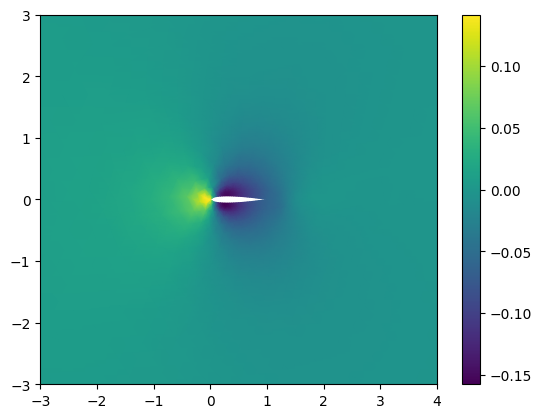

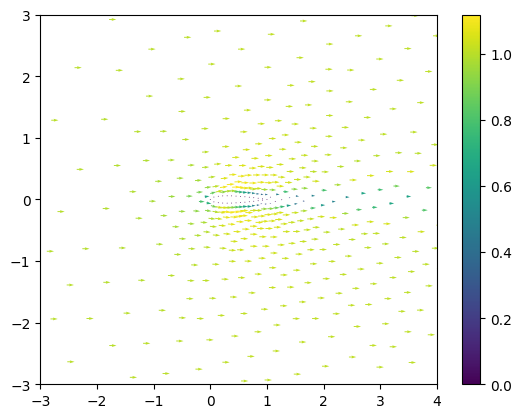

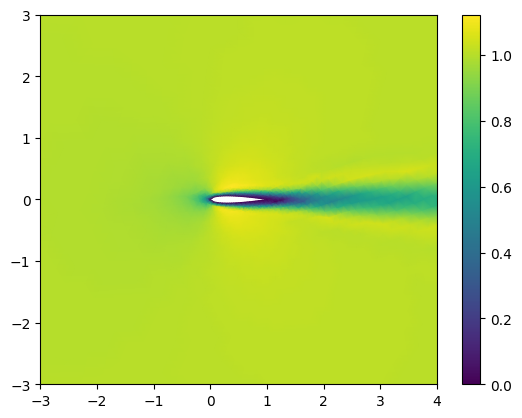

In [ ]:
CFDsolver.plot_solution()

## RL environment

In [14]:
!pip install stable_baselines3

  Using cached gymnasium-0.29.1-py3-none-any.whl.metadata (10 kB)
Using cached gymnasium-0.29.1-py3-none-any.whl (953 kB)
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.0.0
    Uninstalling gymnasium-1.0.0:
      Successfully uninstalled gymnasium-1.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shimmy 2.0.0 requires gymnasium>=1.0.0a1, but you have gymnasium 0.29.1 which is incompatible.


In [8]:
!pip install shimmy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 16.3 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 0.29.1
    Uninstalling gymnasium-0.29.1:
      Successfully uninstalled gymnasium-0.29.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
stable-baselines3 2.3.2 requires gymnasium<0.30,>=0.28.1, but you have gymnasium 1.0.0 which is incompatible.


In [11]:
!pip install gymnasium

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
import numpy as np
import gym
from gym import spaces
from pygem.rbf import RBF

class AirfoilDeformationEnv(gym.Env):
    def __init__(self, initial_mesh, deformation_limits=(-0.1, 0.1)):
        super(AirfoilDeformationEnv, self).__init__()

        # Initialize mesh and CFD solver
        self.initial_mesh = initial_mesh
        self.mesh = Mesh(initial_mesh)
        self.cfd_solver = CFDSolver(self.mesh, 3500)
        self.deformation_limits = deformation_limits

        # Define action space
        self.action_space = spaces.Box(
            low=np.array([self.deformation_limits[0]] * 3, dtype=np.float32),
            high=np.array([self.deformation_limits[1]] * 3, dtype=np.float32),
            dtype=np.float32
        )
        print("Action space initialized:", self.action_space)

        # Define observation space
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=self.mesh.coordinates.dat.data.shape,
            dtype=np.float32
        )
        print("Observation space initialized:", self.observation_space)

        self.reset()

    def step(self, action):
        print("Action received in step:", action)

        # Check if action contains NaNs
        if np.isnan(action).any():
            raise ValueError("NaN detected in action!")

        # Perform mesh deformation
        self.mesh_deformation(action)
        self.cfd_solver = CFDSolver(self.mesh, 3500)

        # Compute Cd and Cl using CFD solver
        Cd, Cl = self.cfd_solver.run_solver()
        self.cfd_solver.plot_solution()

        # Calculate reward
        reward = self.calculate_reward(Cd, Cl)
        done = False  # Continual optimization

        # Observation from mesh coordinates
        observation = self.mesh.coordinates.dat.data
        if np.isnan(observation).any():
            raise ValueError("NaN detected in observation after step!")
        print("Observation after step:", observation)

        return observation, reward, done, {}

    def reset(self):
        print("Resetting environment and mesh")
        self.mesh = Mesh(self.initial_mesh)

        # Confirm no NaNs in reset mesh coordinates
        observation = self.mesh.coordinates.dat.data
        if np.isnan(observation).any():
            raise ValueError("NaN detected in mesh coordinates after reset!")

        return observation

    def mesh_deformation(self, parameters):
        print("Deforming mesh with parameters:", parameters)

        if np.isnan(parameters).any():
            raise ValueError("NaN detected in deformation parameters!")

        coord = self.mesh.coordinates.dat.data
        coord = np.c_[coord, np.ones(coord.shape[0])]
        X = VectorFunctionSpace(self.mesh, 'P', 1)
        b1 = DirichletBC(X, Constant((0., 0.)), 0)
        b2 = DirichletBC(X, Constant((0., 0.)), [1, 2, 3, 4])
        obstacle = coord[b1.nodes, :]
        ext_boundary = coord[b2.nodes, :]

        ffd = FFD([5, 2, 1])
        ffd.box_origin = np.array([-0.2,-0.5,0.9])
        ffd.box_length = np.array([1.4,1,1.1])
        #ffd.array_mu_x[2, 1, 0] = parameters[0]
        ffd.array_mu_y[2,0,0] = parameters[1]
        #ffd.array_mu_z[1, 1, 0] = 0.

        # Apply RBF
        new_obstacle = ffd(obstacle)
        plt.plot(new_obstacle[:,0], new_obstacle[:,1], '.')
        plt.plot(obstacle[:,0], obstacle[:,1], '.')
        plt.axis('equal')
        undeformed_points_full = np.vstack([ext_boundary, obstacle])
        deformed_points_full = np.vstack([ext_boundary, new_obstacle])
        undeformed_points, uindexes = np.unique(undeformed_points_full, return_index=True, axis=0)
        deformed_points = deformed_points_full[uindexes]
        rbf = RBF(original_control_points=undeformed_points, deformed_control_points=deformed_points)
        new_coord = rbf(coord)

        # Update mesh
        new_coords_func = Function(self.mesh.coordinates.function_space())
        new_coords_func.dat.data[:, :2] = new_coord[:, :2]
        self.mesh.coordinates.assign(new_coords_func)

    def calculate_reward(self, Cd, Cl):
        return Cl - Cd  # Example reward


In [ ]:
from stable_baselines3 import PPO


# Define initial mesh and control points of the airfoil
initial_mesh ="testairfoil.msh" # Replace with the mesh data (e.g., as a NumPy array) # Replace with the actual airfoil control points

# Pass necessary configuration if any

# Create the environment with the CFD solver, initial mesh, and control points
env3 = AirfoilDeformationEnv(initial_mesh)

# Create the PPO agent
model = PPO("MlpPolicy", env3, verbose=1)

# Train the agent
model.learn(total_timesteps=100)


Action space initialized: Box(-0.1, 0.1, (3,), float32)
Observation space initialized: Box(-inf, inf, (1020, 2), float32)
Resetting environment and mesh
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Resetting environment and mesh
Action received in step: [ 0.1  0.1 -0.1]
Deforming mesh with parameters: [ 0.1  0.1 -0.1]


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Stokes solution computed and set as initial condition.
Solver converged in 19 iterations
Observation after step: [[ 0.49787351 -0.09757614]
 [ 0.45447334 -0.03424168]
 [ 0.4183528  -0.10185337]
 ...
 [ 9.91263023  0.14025974]
 [10.          0.0868578 ]
 [10.          0.19182205]]
Action received in step: [-0.1 -0.1 -0.1]
Deforming mesh with parameters: [-0.1 -0.1 -0.1]
Stokes solution computed and set as initial condition.
Solver converged in 21 iterations
Observation after step: [[ 0.49787351 -0.11962891]
 [ 0.45447334 -0.05411148]
 [ 0.4183528  -0.12350464]
 ...
 [ 9.91263023  0.1402359 ]
 [10.          0.08685684]
 [10.          0.19181824]]
Action received in step: [-0.1  0.1  0.1]
Deforming mesh with parameters: [-0.1  0.1  0.1]
Stokes solution computed and set as initial condition.
Solver converged in 19 iterations
Observation after step: [[ 0.49787351 -0.09656525]
 [ 0.45447334 -0.0335083 ]
 [ 0.4183528  -0.10095215]
 ...
 [ 9.91263023  0.14025116]
 [10.          0.08685303]
 [1

<ipython-input-32-76db5862f71a>:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


Stokes solution computed and set as initial condition.
Solver converged in 21 iterations
Observation after step: [[ 4.97873505e-01 -4.81586456e-02]
 [ 4.54473339e-01  6.91986084e-03]
 [ 4.18352804e-01 -5.40885925e-02]
 ...
 [ 9.91263023e+00  1.40060425e-01]
 [ 1.00000000e+01  8.69140625e-02]
 [ 1.00000000e+01  1.92138672e-01]]
Action received in step: [ 0.1         0.00434053 -0.1       ]
Deforming mesh with parameters: [ 0.1         0.00434053 -0.1       ]
Stokes solution computed and set as initial condition.
Solver converged in 21 iterations
Observation after step: [[ 4.97873505e-01 -4.72869873e-02]
 [ 4.54473339e-01  7.71427155e-03]
 [ 4.18352804e-01 -5.32293320e-02]
 ...
 [ 9.91263023e+00  1.40060425e-01]
 [ 1.00000000e+01  8.69131088e-02]
 [ 1.00000000e+01  1.92138672e-01]]
Action received in step: [0.1 0.1 0.1]
Deforming mesh with parameters: [0.1 0.1 0.1]
Stokes solution computed and set as initial condition.
Solver converged in 23 iterations
Observation after step: [[ 0.497873

LinAlgError: Singular matrix

Resetting environment and mesh
Action received in step: [-0.00740847  0.00090174 -0.0034468 ]
Deforming mesh with parameters: [-0.00740847  0.00090174 -0.0034468 ]
Stokes solution computed and set as initial condition.
Solver converged in 21 iterations
Observation after step: [[ 0.49787351 -0.11925472]
 [ 0.45447334 -0.05468478]
 [ 0.4183528  -0.12293378]
 ...
 [ 9.91263023  0.14024866]
 [10.          0.08685774]
 [10.          0.19182173]]
Action received in step: [-0.00740848  0.00090182 -0.0034469 ]
Deforming mesh with parameters: [-0.00740848  0.00090182 -0.0034469 ]
Stokes solution computed and set as initial condition.
Solver converged in 21 iterations
Observation after step: [[ 0.49787351 -0.11905746]
 [ 0.45447334 -0.05449876]
 [ 0.4183528  -0.12274222]
 ...
 [ 9.91263023  0.14024876]
 [10.          0.08685775]
 [10.          0.19182174]]
Action received in step: [-0.00740848  0.00090191 -0.003447  ]
Deforming mesh with parameters: [-0.00740848  0.00090191 -0.003447  ]
Stokes s

LinAlgError: Singular matrix

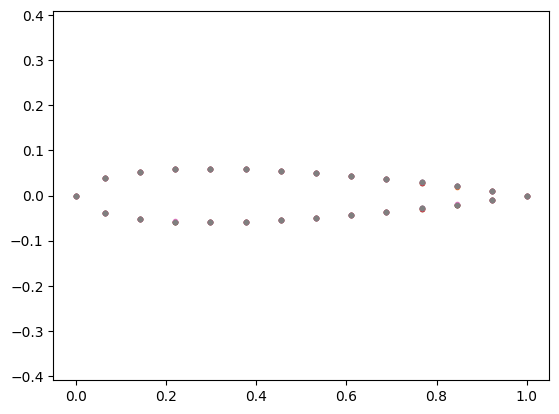

In [ ]:
# Reset environment to get initial state
obs = env3.reset()

# Run the PPO agent to deform the airfoil contour
for _ in range(100):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env3.step(action)
    if done:
        break

# The final `obs` contains the optimized control points for the airfoil.
optimized_control_points = obs
plt.plot(obs[:,0], obs[:,1])